# Translation with a Sequence to Sequence Network and Attention

**Necessary imports**

In [31]:
from __future__ import unicode_literals, print_function, division

# Standard library
import os
import re
import time
import math
import pickle
import csv
import unicodedata
import random
from io import open
from collections import Counter

# Data manipulation
import numpy as np
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, Dataset
from torch.nn.utils.rnn import pad_sequence

# NLP and Metrics
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
nltk.download('wordnet')
nltk.download('omw-1.4')

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading data files and preparing data

Data where dataset is stored and the results will be stored:

In [32]:
data_path = '/content/drive/MyDrive/UPF_DeepLearning_2025/Project2/data/'
results_path = '/content/drive/MyDrive/UPF_DeepLearning_2025/Project2/results/'

We will need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called Lang which has word → index (word2index) and index → word (index2word) dictionaries, as well as a count of each word word2count which will be used to replace rare words later.

In [33]:
SOS_token = 0
EOS_token = 1
UNK_token = 2
PAD_token = 3

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1, "UNK": 2, "PAD": 3}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK", 3: "PAD"}
        self.word2count = {}
        self.n_words = 4  # Count SOS, EOS, UNK, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, we will turn Unicode characters to ASCII, make everything lowercase, and trim punctuation.

In [34]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

To read the data file we will split the file into lines, and then split lines into pairs.

Since the dataset contains many example sentences and we want to speed up training, we'll trim it to include only short sentences and reduce the input and output vocabulary to the most common ones.

In [35]:
MAX_LENGTH = 7 #Used to filter pairs. Just pick the ones with <=MAX_LENGTH words
MIN_COUNT = 4 # Used to trim vocabulary. Pick words seen 4+ times.

def trimRareWords(lang, min_count=MIN_COUNT):
    keep_words = [k for k, v in lang.word2count.items() if v >= min_count]
    print(f"Trimming {lang.name}: from {lang.n_words} to {len(keep_words)} words")

    lang.word2index = {"SOS": 0, "EOS": 1, "UNK": 2}
    lang.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
    lang.n_words = 3
    lang.word2count = {}

    for word in keep_words:
        lang.addWord(word)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def sentenceInVocab(lang, sentence):
    return all(word in lang.word2index for word in sentence.split(' '))

def filterPairsByVocab(pairs, input_lang, output_lang):
    filtered_pairs = []
    for en_sent, es_sent in pairs:
        if sentenceInVocab(input_lang, en_sent) and sentenceInVocab(output_lang, es_sent):
            filtered_pairs.append((en_sent, es_sent))
    return filtered_pairs

In this section, we load the English-Spanish sentence pairs from the dataset and perform basic preprocessing:
- Normalize and clean the text.
- Optionally filter sentence pairs by length or random sampling based on the experiment setup.
- Split the data into training and validation sets using a fixed random seed for reproducibility.
- Build vocabularies for both the source (English) and target (Spanish) languages.
- Trim rare words from the vocabulary to reduce model size and training complexity(for the second experiment).

In [36]:
def readLangsCSV(file_path):
    pairs = []

    with open(file_path, encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header if present: "en,es"

        for row in reader:
            if len(row) < 2:
                continue  # skip bad rows
            en, es = row[0].strip(), row[1].strip()
            if en and es:
                # Normalize strings
                en = normalizeString(en)
                es = normalizeString(es)
                pairs.append([en, es])

    return pairs

def prepareData(file_path, split_ratio=0.9):
    # Split into training and validation
    random.seed(42)
    # Load all pairs
    all_pairs = readLangsCSV(file_path)
    print("Read %s sentence pairs" % len(all_pairs))
    # all_pairs = all_pairs[:10000] # pick first 10k samples. 1st experiment
    all_pairs = filterPairs(all_pairs) # pick sentences with >= MAX_LENGTH. 2nd experiment
    # all_pairs = random.sample(all_pairs, 60000) # pick 60k random pairs of samples. 3rd experiment

    print("Trimmed to %s sentence pairs" % len(all_pairs))

    #Split into training and validating
    train_pairs, val_pairs = train_test_split(all_pairs, test_size=(1 - split_ratio), random_state=42)
    print("Training pairs: %s" % len(train_pairs))
    print("Validation pairs: %s" % len(val_pairs))

    # Create input/output langs based on training data
    input_lang = Lang('en')
    output_lang = Lang('es')

    print("Counting words in training data...")
    for pair in train_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    # Reduce vocabulary by reducing vocabulary to words seen MIN_COUNT+ times( 2nd experiment)
    trimRareWords(input_lang)
    trimRareWords(output_lang)

    return input_lang, output_lang, train_pairs, val_pairs

# Prepare data
input_lang, output_lang, train_pairs, val_pairs = prepareData(data_path + 'data.csv')

print(random.choice(train_pairs))

Read 118964 sentence pairs
Trimmed to 56713 sentence pairs
Training pairs: 51041
Validation pairs: 5672
Counting words in training data...
Counted words:
en 8127
es 14634
Trimming en: from 8127 to 3354 words
Trimming es: from 14634 to 4519 words
['tom doesn t work here', 'tom no trabaja aqui']


In [37]:
all_pairs = readLangsCSV(data_path + 'data.csv')
print("Read %s sentence pairs" % len(all_pairs))

Read 118964 sentence pairs


### Data Exploration and Visualization

Before training, it is important to analyze the dataset to better understand its characteristics:
- `plot_sentence_lengths(pairs)`: Plots the distribution of sentence lengths (in words) for both source (English) and target (Spanish) sentences.
- `plot_vocab_distribution(pairs, top_k=20)`: Displays the top-K most frequent words in the source and target vocabularies.

In [38]:
def plot_sentence_lengths(pairs):
    src_lengths = [len(s.split()) for s, _ in pairs]
    tgt_lengths = [len(t.split()) for _, t in pairs]

    plt.figure(figsize=(12, 6))
    sns.histplot(src_lengths, color="blue", label="Source", bins=30)
    sns.histplot(tgt_lengths, color="green", label="Target", bins=30)
    plt.xlabel("Sentence Length (words)")
    plt.ylabel("Count")
    plt.title("Distribution of Sentence Lengths")
    plt.xlim(0, 25)  # max word length
    plt.legend()
    plt.show()

def plot_vocab_distribution(pairs, top_k=20):
    src_counter = Counter()
    tgt_counter = Counter()

    for src, tgt in pairs:
        src_counter.update(src.split())
        tgt_counter.update(tgt.split())

    src_vocab_size = len(src_counter)
    tgt_vocab_size = len(tgt_counter)

    print(f"Source Vocabulary Size: {src_vocab_size}")
    print(f"Target Vocabulary Size: {tgt_vocab_size}")

    # Top-K frequent words
    src_common = src_counter.most_common(top_k)
    tgt_common = tgt_counter.most_common(top_k)

    # Plot Source
    words_src, counts_src = zip(*src_common)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts_src), y=list(words_src), palette="Blues_d", hue=list(words_src), legend=False)
    plt.title(f"Top {top_k} Frequent Words in Source")
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.show()

    # Plot Target
    words_tgt, counts_tgt = zip(*tgt_common)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts_tgt), y=list(words_tgt), palette="Greens_d", hue=list(words_tgt), legend=False)
    plt.title(f"Top {top_k} Frequent Words in Target")
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.show()

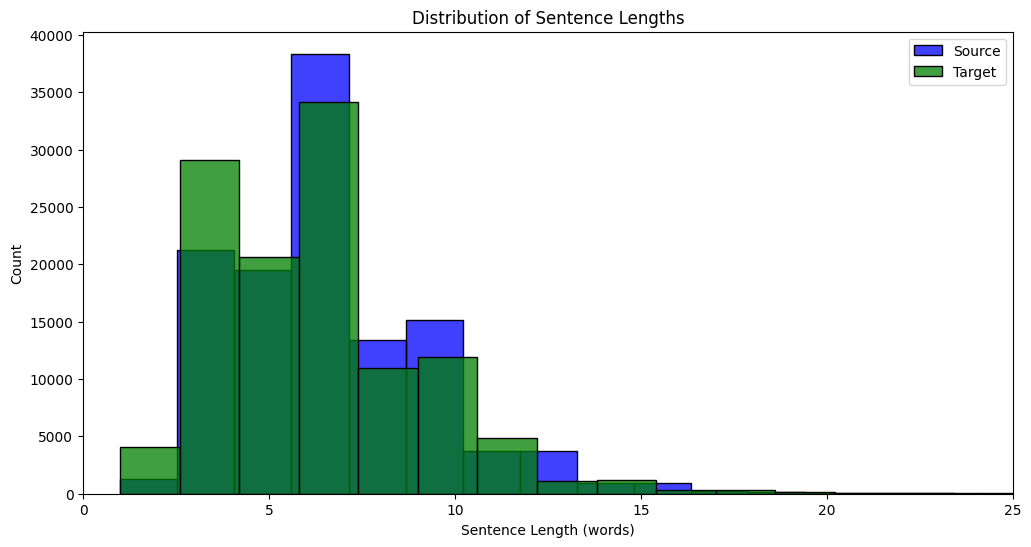

Source Vocabulary Size: 12929
Target Vocabulary Size: 24790


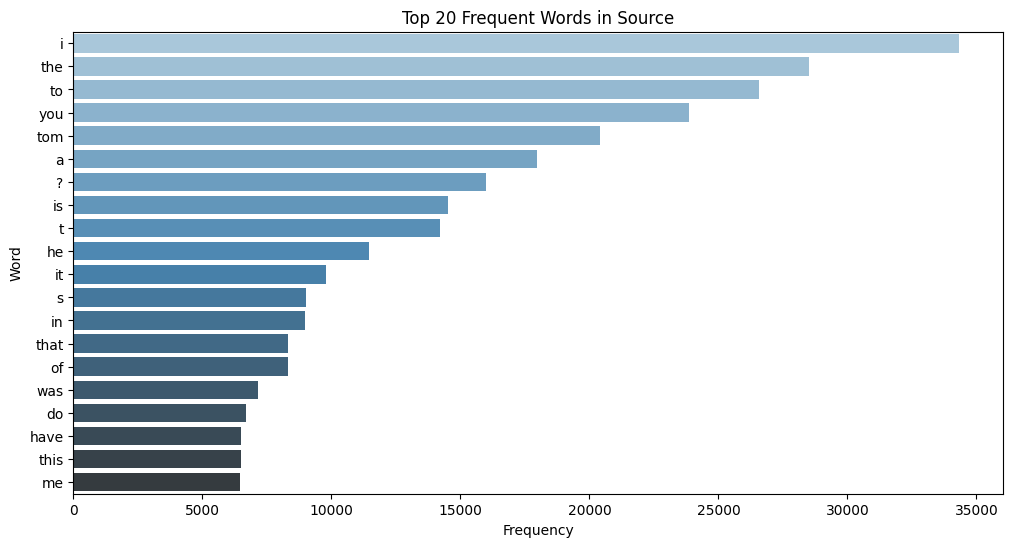

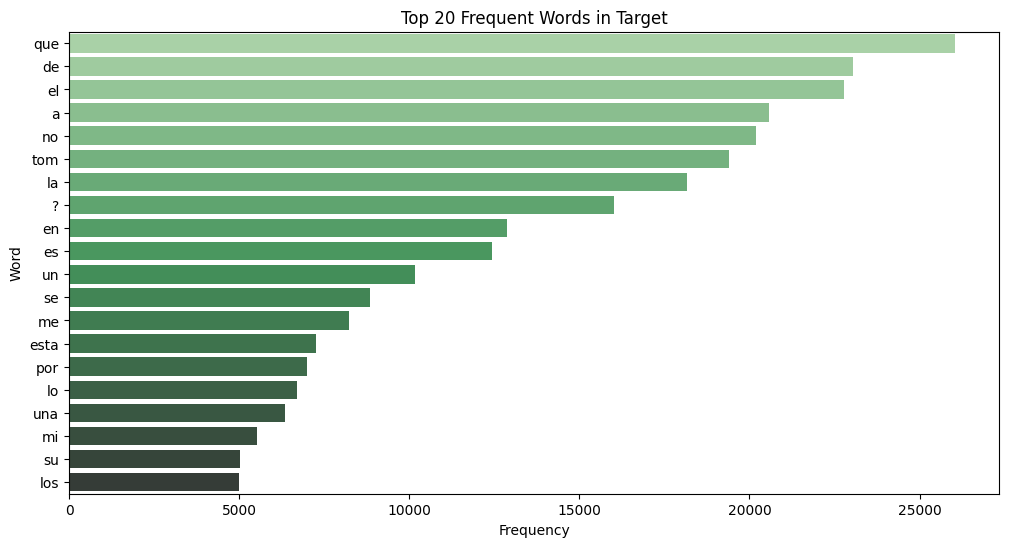

In [39]:
#Plot the word and sentence length distribution of the whole dataset(before trimming)
plot_sentence_lengths(all_pairs)
plot_vocab_distribution(all_pairs, top_k=20)

### Preparing Training Data
To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [40]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word, lang.word2index['UNK']) for word in sentence.split(' ')] # Index mapping, unknown words are replaced with 'UNK' index.

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def collate_fn(batch):
    # Separates inputs and targets
    inputs, targets = zip(*batch)

    # Pad sequences dynamically
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=PAD_token) # takes a list of tensors of different lengths and pads them to the same length.
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=PAD_token)

    return inputs_padded, targets_padded


class TranslationDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

def get_dataloader(batch_size, input_lang, output_lang, train_pairs):
    inputs = []
    targets = []

    for inp, tgt in train_pairs:
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        inputs.append(torch.LongTensor(inp_ids))
        targets.append(torch.LongTensor(tgt_ids))

    # Create Dataset
    train_dataset = TranslationDataset(inputs, targets)

    # Create DataLoader with collate_fn
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    return train_dataloader

In [41]:
#Initialize the dataloader
batch_size = 64
train_dataloader = get_dataloader(batch_size, input_lang, output_lang, train_pairs)
val_dataloader = get_dataloader(batch_size, input_lang, output_lang, val_pairs)

## The Seq2Seq Model

### The encoder

In [42]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.3):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### Attention and Decoder

In [43]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
       # Calculate attention scores
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys))) # (batch_size, seq_len, 1)

        # Squeeze last dimension and unsqueeze to match (batch_size, 1, seq_len) for softmax
        scores = scores.squeeze(2).unsqueeze(1)

        # Softmax over encoder time steps to get attention weights
        weights = F.softmax(scores, dim=-1)

        # Softmax over encoder time steps to get attention weights
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.3):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        if target_tensor is not None:
            max_target_length = target_tensor.size(1)
        else:
            max_target_length = 50  # maximum steps if no target available (inference)

        for i in range(max_target_length):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # inference

        decoder_outputs = torch.cat(decoder_outputs, dim=1) #Concatenate all output logits
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1) #get log probabilities
        attentions = torch.cat(attentions, dim=1) # Concatenate attention maps across time.

        return decoder_outputs, decoder_hidden, attentions



    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

## Training

### Training the Model
To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

- `train_epoch()`: Performs a single epoch of training, updating model parameters based on the computed loss.
- `evaluate_epoch()`: Evaluates the model on the validation set without updating parameters, returning the average validation loss.
- `asMinutes()` and `timeSince()`: Utility functions for formatting elapsed and estimated remaining training time, helping to monitor training progress.

This setup allows us to monitor performance over time and ensures that we retain the best model during training.

In [44]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):
    encoder.train()
    decoder.train()
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [45]:
def evaluate_epoch(val_dataloader, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    total_loss = 0

    with torch.no_grad():
        for input_tensor, target_tensor in val_dataloader:
            input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, decoder_hidden, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            # Flatten to compute loss
            loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
            total_loss += loss.item()

    return total_loss / len(val_dataloader)  # average loss

`train`: Complete Training Loop Across Epochs

This function brings everything together. It loops over several epochs, and in each epoch it:

- Calls `train_epoch` to train the model.
- Calls `val_epoch` to evaluate it.
- Tracks and stores the training and validation metrics (loss and accuracy).
- Measures time per epoch.
- Saves the model whenever it reaches a new best validation loss.

In [46]:
def train(train_dataloader, val_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
          print_every=1, model_name: str = "best_model.pt"):

    start = time.time()
    train_losses = []
    val_losses = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate, weight_decay = 1e-4)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate, weight_decay = 1e-4)
    criterion = nn.NLLLoss()

    best_val_loss = float('inf')
    best_epoch = 1

    for epoch in range(1, n_epochs + 1):
        encoder.train()
        decoder.train()

        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        val_loss = evaluate_epoch(val_dataloader, encoder, decoder, criterion)

        train_losses.append(loss)
        val_losses.append(val_loss)

        if epoch % print_every == 0:
            print('%s (%d %d%%) Train Loss: %.4f, Val Loss: %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, loss, val_loss))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            # Save model
            torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
                'loss': loss,
                'epoch': epoch
            }, os.path.join(results_path, f"{model_name}.pt"))

    print(f"Saved new best model at epoch {best_epoch} with val loss {best_val_loss:.4f}")

    return train_losses, val_losses

Next, we will:
- Initialize and move the encoder and decoder models to the appropriate device (CPU or GPU).
- Compute and print the total number of trainable parameters.
- Start the training loop, saving the best model based on validation loss and saving the losses

In [47]:
hidden_size = 256
batch_size = 64

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

#Printing the total number of parameters
total_params_enc = sum(p.numel() for p in encoder.parameters())
print(f"Total trainable parameters in encoder: {total_params_enc}")
total_params_dec = sum(p.numel() for p in decoder.parameters() if p.requires_grad)
print(f"Total trainable parameters in decoder: {total_params_dec}")
print(f"Total trainable parameters: {total_params_enc + total_params_dec}")

losses_list, val_list = train(train_dataloader, val_dataloader, encoder, decoder, 20, print_every=1, model_name="alldataset.pt" )

Total trainable parameters in encoder: 1254144
Total trainable parameters in decoder: 3042987
Total trainable parameters: 4297131
3m 21s (- 63m 42s) (1 5%) Train Loss: 2.9291, Val Loss: 2.1173
6m 40s (- 60m 2s) (2 10%) Train Loss: 1.9461, Val Loss: 1.6529
10m 0s (- 56m 42s) (3 15%) Train Loss: 1.5528, Val Loss: 1.3901
13m 20s (- 53m 21s) (4 20%) Train Loss: 1.3105, Val Loss: 1.2340
16m 42s (- 50m 6s) (5 25%) Train Loss: 1.1537, Val Loss: 1.1465
20m 5s (- 46m 53s) (6 30%) Train Loss: 1.0533, Val Loss: 1.0966
23m 32s (- 43m 42s) (7 35%) Train Loss: 0.9848, Val Loss: 1.0542
26m 55s (- 40m 23s) (8 40%) Train Loss: 0.9359, Val Loss: 1.0296
30m 25s (- 37m 11s) (9 45%) Train Loss: 0.8984, Val Loss: 1.0194
33m 49s (- 33m 49s) (10 50%) Train Loss: 0.8707, Val Loss: 1.0090
37m 24s (- 30m 36s) (11 55%) Train Loss: 0.8496, Val Loss: 0.9966
40m 52s (- 27m 15s) (12 60%) Train Loss: 0.8323, Val Loss: 0.9892
44m 13s (- 23m 48s) (13 65%) Train Loss: 0.8164, Val Loss: 0.9888
47m 32s (- 20m 22s) (14 70%)

## Plotting results
Plot training and validation loss during training, using the array of loss
and validation values saved while training.

In [48]:
def plot_metrics(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, marker='o', linestyle='-', color='blue', label='Train Loss')
    plt.plot(epochs, val_losses, marker='o', linestyle='-', color='orange', label='Validation Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

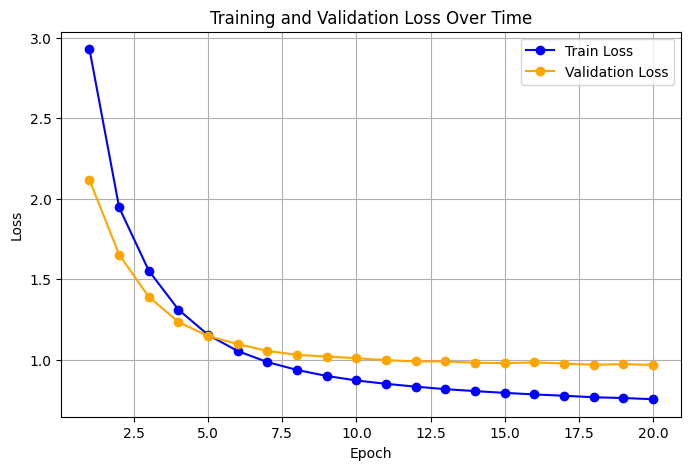

In [49]:
plot_metrics(losses_list, val_list)

## Evaluation

We evaluated the model using `BLEU` and `METEOR` metrics:
- `evaluate`: Generates the output sequence for a given input sentence using the trained encoder and decoder.


In [68]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1) # Take the index of the word with the highest score
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

We can evaluate random traductions, to have a subjective metric of how the model is responding.

In [51]:
def evaluateRandomly(encoder, decoder, val_pairs, n=10):
    for i in range(n):
        pair = random.choice(val_pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

`evaluateRandomlyWBleuMeteor()` function randomly selects sample sentences from the validation set and displays:
  - The input sentence (source).
  - The ground truth translation (target).
  - The model's predicted translation (output).
  - The individual BLEU and METEOR scores for each sample.

In [52]:
def evaluateRandomlyWBleuMeteor(encoder, decoder, val_pairs, n=10):
    smooth_fn = SmoothingFunction().method1
    total_bleu = 0.0
    total_meteor = 0.0

    for i in range(n):
        pair = random.choice(val_pairs)
        print(f'> {pair[0]}')     # Input sentence
        print(f'= {pair[1]}')     # Target sentence

        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)

        # Remove <EOS> if present
        if '<EOS>' in output_words:
            output_words = output_words[:output_words.index('<EOS>')]

        output_sentence = ' '.join(output_words)
        print(f'< {output_sentence}')  # Predicted sentence

        # Prepare references and hypothesis (tokenized)
        reference = pair[1].split()  # list of tokens
        hypothesis = output_words   # list of tokens

        # Calculate BLEU
        bleu_score = sentence_bleu([reference], hypothesis, smoothing_function=smooth_fn)
        total_bleu += bleu_score

        # Calculate METEOR
        meteor = meteor_score([reference], hypothesis)
        total_meteor += meteor

        print(f'BLEU score: {bleu_score:.4f}')
        print(f'METEOR score: {meteor:.4f}\n')

    avg_bleu = total_bleu / n
    avg_meteor = total_meteor / n
    print(f'Average BLEU score over {n} samples: {avg_bleu:.4f}')
    print(f'Average METEOR score over {n} samples: {avg_meteor:.4f}')

- `computeCorpusBLEU`: Calculates the corpus-level BLEU score, a standard metric for evaluating machine translation quality, with smoothing to handle short sentences.
- `compute_meteor`: Computes the average METEOR score, which considers synonyms and stemmed variations to provide a semantically richer evaluation.

In [53]:
def computeCorpusBLEU(encoder, decoder, eval_pairs, input_lang, output_lang):
    smooth_fn = SmoothingFunction().method1

    references = []
    hypotheses = []

    for pair in eval_pairs:
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words, _ = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)

        # Remove <EOS> if present
        if '<EOS>' in output_words:
            output_words = output_words[:output_words.index('<EOS>')]

        # Prepare reference and hypothesis
        reference = [target_sentence.split()]  # List of tokens wrapped in a list
        hypothesis = output_words

        if len(hypothesis) == 0:
            continue  # skip bad empty translations

        references.append(reference)
        hypotheses.append(hypothesis)

    # Compute corpus BLEU
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smooth_fn)
    print(f'BLEU score: {bleu_score:.4f}')
    return bleu_score

def compute_meteor(encoder, decoder, val_pairs, input_lang, output_lang):
    total_meteor = 0.0

    for pair in val_pairs:
        input_sentence = pair[0]
        reference_sentence = pair[1]

        # Get model prediction
        output_words, _ = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        predicted_sentence = ' '.join(output_words).replace('<EOS>', '').strip()

        # Remove <EOS> if present
        if '<EOS>' in output_words:
            output_words = output_words[:output_words.index('<EOS>')]

        # Prepare for METEOR
        reference = [reference_sentence.split()]  # Tokenize reference
        hypothesis = predicted_sentence.split()   # Tokenize hypothesis

        # Compute METEOR
        score = meteor_score(reference, hypothesis)
        total_meteor += score

    avg_meteor = total_meteor / len(val_pairs)
    print(f'Average METEOR: {avg_meteor:.4f}')
    return avg_meteor

In [54]:
encoder.eval()
decoder.eval()
evaluateRandomlyWBleuMeteor(encoder, decoder, val_pairs)

> keep smiling
= sigan sonriendo
< manten sonriendo UNK
BLEU score: 0.1136
METEOR score: 0.2381

> tom is interested in mountaineering
= tom esta interesado en el montanismo
< tom esta interesado en la UNK
BLEU score: 0.5081
METEOR score: 0.6615

> were you here last week ?
= estuviste aqui la semana pasada ?
< estabas aqui la semana pasada ?
BLEU score: 0.7598
METEOR score: 0.8300

> i get anything i want
= yo obtengo lo que quiero
< entiendo lo que quiero
BLEU score: 0.3097
METEOR score: 0.6009

> i have a stomachache doctor
= doctor me duele mi estomago
< tengo un UNK de UNK
BLEU score: 0.0000
METEOR score: 0.0000

> he looks older than my brother
= el parece mayor que mi hermano
< el parece mayor que mi hermano
BLEU score: 1.0000
METEOR score: 0.9977

> children always want to become adults
= los ninos siempre quieren hacerse mayores
< los ninos siempre quieren ser UNK
BLEU score: 0.5081
METEOR score: 0.6615

> tom didn t seem to care
= a tom no parecia importarle
< tom no se UNK
B

In [55]:
bleu_score = computeCorpusBLEU(encoder, decoder, val_pairs, input_lang, output_lang)

BLEU score: 0.2965


In [56]:
meteor = compute_meteor(encoder, decoder, val_pairs, input_lang, output_lang)

Average METEOR: 0.5295


## Visualizing Attention

Attention visualizations help explain the model's behavior, highlighting how it aligns source and target tokens during translation.

- `showAttention()`: Visualizes the attention weights as a heatmap, showing which input tokens the decoder attends to at each output step.
- `evaluateAndShowAttention()`: Generates a prediction for a given input sentence and displays its corresponding attention map.
- `showRandomValidationAttention(n)`: Randomly selects sentences from the input set of pairs and visualizes their attention.

In [69]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Token list for x-axis and y-axis
    input_tokens = input_sentence.split(' ') + ['<EOS>']
    output_tokens = output_words

    # Set ticks and labels explicitly
    ax.set_xticks(range(len(input_tokens)))
    ax.set_xticklabels(input_tokens, rotation=90)

    ax.set_yticks(range(len(output_tokens)))
    ax.set_yticklabels(output_tokens)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


def showRandomValidationAttention(n=5, pairs=val_pairs):
    for _ in range(n):
        pair = random.choice(pairs)
        input_sentence = pair[0]  # English sentence
        evaluateAndShowAttention(input_sentence)

Print attention matrix for 3 randomly picked sentances from validation

input = nobody has solved the problem
output = nadie ha resuelto el problema <EOS>


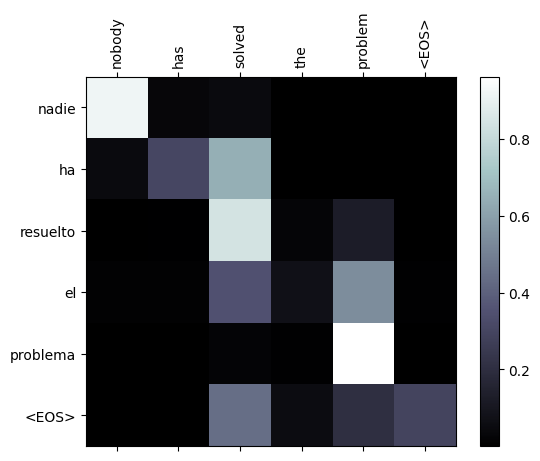

input = tom stole something from my house
output = tom robo algo de mi casa <EOS>


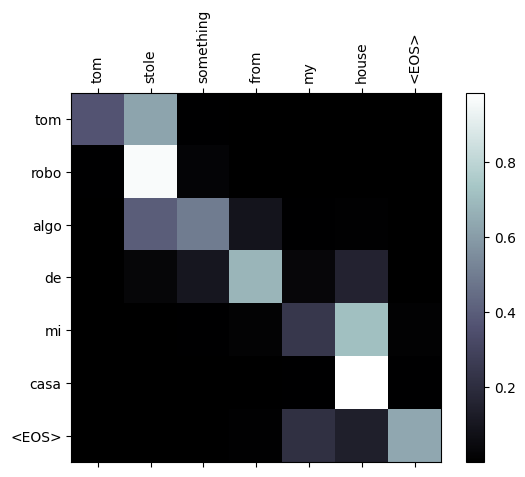

input = where do you live ?
output = donde vives ? <EOS>


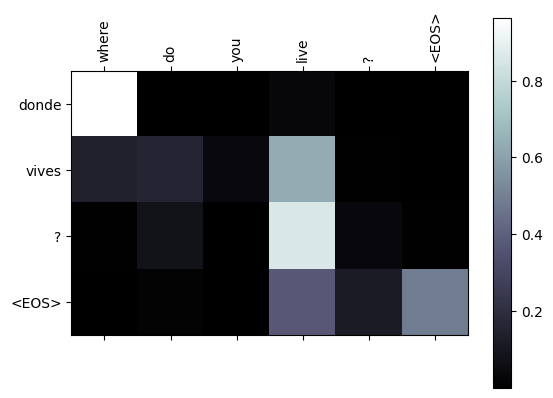

In [73]:
showRandomValidationAttention(3, val_pairs)

# Add Pretrained Word Embeddings
Now, we will use pretrained embeddings (Word2Vec) to improve translation performance by leveraging existing semantic knowledge of words. We will:
- Load pretrained embeddings (from Gensim).

- Create an embedding matrix aligned with the vocabulary.

- Define new encoder and decoder using these weights.

- Initialize your model's embedding layer with this matrix.

## Preprocessing
Load Word2Vec Embeddings
- Loads a pretrained Word2Vec model trained on Google News.

- Each word is mapped to a 300-dimensional vector.

- This model is ~1.5 GB and has a large vocabulary.

This uninstall/install commands  might be necessary for version compatibility
Restart session if necessary

In [59]:
#!pip uninstall -y gensim numpy scipy
#!pip install numpy==1.23.5 scipy==1.10.1 gensim==4.3.1

In [60]:
import gensim.downloader as api

# Load pretrained word2vec vectors
word2vec = api.load("word2vec-google-news-300") # 1.5 GB

ModuleNotFoundError: No module named 'gensim'

Build an embedding matrix
- Construct an embedding_matrix that aligns with your vocabulary input_lang.word2index.

- For words not found in Word2Vec, you initialize random vectors.

- This matrix will be used to initialize the weights of a PyTorch embedding layer.

In [ ]:
embedding_dim = 300
vocab_size = len(input_lang.word2index)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in input_lang.word2index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim))

## Model Architecture
EncoderRNNPretrained
- Uses the embedding layer → dropout → GRU
- Accepts input sequences, embeds them, and processes with a GRU to produce hidden states.

Same decoder as before

In [ ]:
class EncoderRNNPretrained(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_layer, dropout_p=0.3):
        super(EncoderRNNPretrained, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding_layer
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.3):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        if target_tensor is not None:
            max_target_length = target_tensor.size(1)
        else:
            max_target_length = 50  # maximum steps if no target available (inference)

        for i in range(max_target_length):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # inference

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions



    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

##Training
Create a Trainable Embedding Layer
- from_pretrained(...) uses the embedding_tensor to create a nn.Embedding layer.

- freeze=False ensures the embedding weights are trainable

In [ ]:
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)
embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=False)
# The hidden size of the GRU should match the embedding dimension
batch_size = 64
hidden_size = 300 # size of word2vec embeddings

# Re-instantiate the models with the updated hidden_size
encoder_pretrained = EncoderRNNPretrained(input_lang.n_words, hidden_size, embedding_layer).to(device)
# The decoder's hidden size also needs to match the encoder's output hidden size
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
#Print the total number of parameters
total_params = sum(p.numel() for p in encoder_pretrained.parameters()) + sum(p.numel() for p in decoder.parameters())
print(f"Total number of parameters: {total_params}")

# Now we can proceed with training
losses_list_pretrained, val_list_pretrained = train(train_dataloader, val_dataloader, encoder_pretrained, decoder, 20, print_every=1, model_name = "pretrained.pt" )

## Results and Evaluation
Evaluate and see final results for the final trained model with pre-trained word embeddings.

This evaluation helps establish whether incorporating pretrained embeddings leads to superior translation quality compared to models trained from scratch.


In [ ]:
encoder_pretrained.eval()
decoder.eval()

In [ ]:
plot_metrics(losses_list_pretrained, val_list_pretrained)

In [ ]:
evaluateRandomlyWBleuMeteor(encoder_pretrained, decoder,val_pairs)

In [ ]:
computeCorpusBLEU(encoder_pretrained, decoder, val_pairs, input_lang, output_lang)

In [ ]:
compute_meteor(encoder_pretrained, decoder, val_pairs, input_lang, output_lang)